This notebook extracts building ground and roadway elevations using building footprint file, building points with GSV metadata, and DEM rasters.

## Import dependencies
* Functions on geometry restoration are contained in the geometry.py module.

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import numpy as np
import os
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.mask
from shapely.geometry import Point, Polygon
from tqdm import tqdm

## Set input files
* Building points file containing GSV panorama metadata
* Building footprint file
* DEM raster files

In [36]:
## Launceston
# building_point_file=r'D:\Launceston\GSV\LC_Final_meta_camera_height.geojson'
# building_footprint_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\overture\launceston_building.gpkg'
# dem_vrt_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\GA_data_documentation\Launceston DEM\1m_DEM.vrt'

In [37]:
# Wagga
building_point_file=r'D:\Wagga\GSV\Final_Wagga_meta_camera_height.geojson'
building_footprint_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\overture\wagga_building.gpkg'
dem_vrt_file=r'C:\Users\lliu\FrontierSI\Projects - 127 Residential Dwelling Floor Height\4 Executing\Data Exploration\Wagga DEM\NSW_2020_DEM_1m.vrt'

## Read in building points file and extract GSV camera locations

In [38]:
gdf_points=gpd.read_file(building_point_file).to_crs('epsg:4326')
gdf_points.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,pano_id,lat_c,lng_c,heading,pitch,roll,elevation,date,height_c,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,OhWlnnBJMpUtuvp3gak-8Q,-35.102543,147.349046,0.169123,-0.014912,6.252468,181.957260,2019-09,2.373121,POINT (147.34855 -35.1025)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (147.34797 -35.10244)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (147.34698 -35.10443)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,BLJvkN33DWrwpEKVa7q-wQ,-35.104924,147.348552,0.161009,0.002666,6.254132,181.549530,2019-09,2.824892,POINT (147.34792 -35.10482)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,PoUl3uYBjG4p2dgCVbWo9g,-35.103220,147.348914,0.147912,0.003101,6.249268,181.555573,2019-09,2.439367,POINT (147.34845 -35.10319)


In [39]:
gdf_camera=gdf_points.copy()
gdf_camera['geometry'] = gdf_camera.apply(lambda row: Point(row['lng_c'], row['lat_c']), axis=1)
gdf_camera.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,pano_id,lat_c,lng_c,heading,pitch,roll,elevation,date,height_c,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,OhWlnnBJMpUtuvp3gak-8Q,-35.102543,147.349046,0.169123,-0.014912,6.252468,181.957260,2019-09,2.373121,POINT (147.34905 -35.10254)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (NaN NaN)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (NaN NaN)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,BLJvkN33DWrwpEKVa7q-wQ,-35.104924,147.348552,0.161009,0.002666,6.254132,181.549530,2019-09,2.824892,POINT (147.34855 -35.10492)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,PoUl3uYBjG4p2dgCVbWo9g,-35.103220,147.348914,0.147912,0.003101,6.249268,181.555573,2019-09,2.439367,POINT (147.34891 -35.10322)


## Reproject to keep consistency with raster file

In [40]:
# Open the raster to get its CRS
with rasterio.open(dem_vrt_file) as src:
    raster_crs = src.crs
raster_crs

CRS.from_epsg(7855)

In [41]:
gdf_footprint=gpd.read_file(building_footprint_file).to_crs(raster_crs)
gdf_footprint.head()

,min_height_ahd,max_height_ahd,geometry
0,260.380,261.404,"POLYGON ((526929.366 6108227.811, 526923.327 6..."
1,263.089,264.092,"POLYGON ((526932.949 6108256.742, 526929.971 6..."
2,262.491,262.949,"POLYGON ((526972.892 6108265.607, 526967.864 6..."
3,264.359,264.692,"POLYGON ((527037.881 6108335.54, 527034.092 61..."
4,277.474,277.954,"POLYGON ((526490.129 6108485.901, 526482.165 6..."


In [42]:
gdf_camera=gdf_camera.to_crs(raster_crs)
gdf_camera

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,pano_id,lat_c,lng_c,heading,pitch,roll,elevation,date,height_c,geometry
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,OhWlnnBJMpUtuvp3gak-8Q,-35.102543,147.349046,0.169123,-0.014912,6.252468,181.957260,2019-09,2.373121,POINT (531811.317 6115529.514)
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (Infinity Infinity)
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (Infinity Infinity)
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,BLJvkN33DWrwpEKVa7q-wQ,-35.104924,147.348552,0.161009,0.002666,6.254132,181.549530,2019-09,2.824892,POINT (531765.334 6115265.637)
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,PoUl3uYBjG4p2dgCVbWo9g,-35.103220,147.348914,0.147912,0.003101,6.249268,181.555573,2019-09,2.439367,POINT (531799 6115454.493)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,Brick,1,Commercial,2,ROBERT,9 STURT STREET,617.507956,4.4999,-9999.0000,-9999.0,...,AWYl-KhhMn2a4fCREJqU3A,-35.105554,147.370953,1.226852,-0.015698,6.242893,185.438202,2022-06,2.808793,POINT (533806.651 6115188.311)
3460,Metal,1,Commercial,1,ROBERT,40-42 DOBNEY AVENUE,575.654113,2.3451,-9999.0000,-9999.0,...,lpc-avq_E8VIEf3T7XBVKQ,-35.121410,147.344241,3.642922,0.000996,6.260234,183.763367,2022-06,2.208911,POINT (531366.143 6113438.716)
3461,Metal,1,Commercial,1,ROBERT,5-7 PEARSON STREET,486.717293,1.0711,-9999.0000,-9999.0,...,e517zGz1x21ZdoLIgIiFEA,-35.122648,147.344012,0.128576,0.021735,6.274247,184.399139,2020-11,2.072858,POINT (531344.811 6113301.476)
3462,Metal,1,Industrial,1,ROBERT,9 PEARSON STREET,981.409060,1.7889,-9999.0000,-9999.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,POINT (Infinity Infinity)


## Define functions for zonal statistics calculation

In [43]:
# define zonal aggregation operation mapping
mapping_stats = {
    "mean": np.mean,
    "max": np.max,
    "min": np.min,
    "median": np.median,
    "sum": np.sum,
    "std": np.std,
    "count": len
}

# Function to calculate statistics for a single geometry
def calculate_stats(raster, geometry, operation):
    # Mask the raster with the geometry
    out_image, out_transform = rasterio.mask.mask(raster, [geometry], crop=True, nodata=raster.nodata)
    data = out_image[0]
    # Exclude nodata values
    data = data[data != raster.nodata]
    if data.size == 0:
        return None  # No valid data within the zone
    stats=mapping_stats[operation](data)
    return stats

## Implement zonal statistics to get ground elevations
* matching building footprint with the nearest GSV pano location

In [44]:
gdf_points_updated=gdf_points.copy().to_crs(raster_crs)
elevs_camera=[]
min_elev_bdgs=[]
mean_elev_bdgs=[]
max_elev_bdgs=[]
# Open the VRT file
with rasterio.open(dem_vrt_file) as rst:
    # Calculate zonal statistics for each zone
    stats_list = []
    for idx, point in tqdm(gdf_points_updated.iterrows(),total=len(gdf_points_updated)):
        # get elevations of GSV camera roadway
        elev_camera=calculate_stats(rst, point.geometry, 'mean')
        elevs_camera.append(elev_camera)
        # Find the nearest building footprint
        gdf_footprint['distance']=gdf_footprint['geometry'].apply(lambda x: point.geometry.distance(x))
        nearest_poly = gdf_footprint.loc[gdf_footprint['distance'].idxmin()]
        # get ground elevation of building
        min_elev_bdg=calculate_stats(rst, nearest_poly.geometry, 'min')
        mean_elev_bdg=calculate_stats(rst, nearest_poly.geometry, 'mean')
        max_elev_bdg=calculate_stats(rst, nearest_poly.geometry, 'max')
        min_elev_bdgs.append(min_elev_bdg)
        mean_elev_bdgs.append(mean_elev_bdg)
        max_elev_bdgs.append(max_elev_bdg)

100%|██████████| 3464/3464 [57:22<00:00,  1.01it/s]  


In [45]:
# assign new columns for storing statistics
gdf_points_updated['grd_elev_GSV'] = elevs_camera
gdf_points_updated['grd_elev_building_min'] = min_elev_bdgs
gdf_points_updated['grd_elev_building_mean'] = mean_elev_bdgs
gdf_points_updated['grd_elev_building_max'] = max_elev_bdgs
gdf_points_updated.head()

,WALL_M,STEPS,USAGE,STOREYS,ASSESSOR,address,Area_1,PMF,Dep_500,Dep_200,...,pitch,roll,elevation,date,height_c,geometry,grd_elev_GSV,grd_elev_building_min,grd_elev_building_mean,grd_elev_building_max
0,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,721.960449,3.6338,-9999.0000,-9999.0,...,-0.014912,6.252468,181.957260,2019-09,2.373121,POINT (531766.431 6115534.538),178.937820,178.845871,178.967148,179.160858
1,Metal,1,Commercial,1,ROBERT,3 MOORONG STREET,314.036351,3.4780,-9999.0000,-9999.0,...,NaN,NaN,NaN,None,NaN,POINT (531713.009 6115541.678),179.142853,178.902161,179.128693,179.328049
2,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,1783.805231,3.2973,0.9431,-9999.0,...,NaN,NaN,NaN,None,NaN,POINT (531622.148 6115320.487),178.917725,178.355988,178.935410,179.249023
3,Metal,1,Commercial,1,ROBERT,UNIT 1 29 MOORONG STREET,346.207850,4.6240,-9999.0000,-9999.0,...,0.002666,6.254132,181.549530,2019-09,2.824892,POINT (531707.773 6115277.767),179.069473,178.978210,179.106476,179.214050
4,Metal,1,Commercial,1,ROBERT,11 MOORONG STREET,615.235606,3.4026,-9999.0000,-9999.0,...,0.003101,6.249268,181.555573,2019-09,2.439367,POINT (531756.903 6115457.675),179.030899,178.842987,179.065598,179.153915


### View derived elevations

(array([ 274.,  684., 1019.,  690.,  475.,  176.,   75.,   53.,   15.,
           3.]),
 array([177.55335999, 178.29923859, 179.04511719, 179.79099579,
        180.53687439, 181.28275299, 182.02863159, 182.77451019,
        183.52038879, 184.2662674 , 185.012146  ]),
 <BarContainer object of 10 artists>)

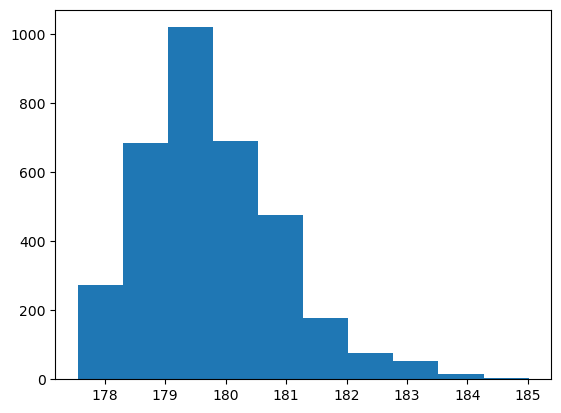

In [46]:
plt.hist([h for h in gdf_points_updated['grd_elev_GSV'] if h is not None])

(array([153., 515., 949., 781., 523., 305., 130.,  71.,  25.,  12.]),
 array([177.2727356 , 177.96215973, 178.65158386, 179.341008  ,
        180.03043213, 180.71985626, 181.4092804 , 182.09870453,
        182.78812866, 183.4775528 , 184.16697693]),
 <BarContainer object of 10 artists>)

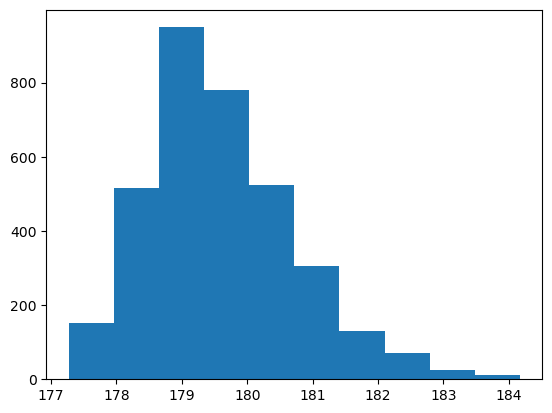

In [47]:
plt.hist([h for h in gdf_points_updated['grd_elev_building_min'] if h is not None])

(array([ 278.,  724., 1052.,  670.,  438.,  176.,   58.,   49.,   15.,
           4.]),
 array([177.62709045, 178.41825714, 179.20942383, 180.00059052,
        180.7917572 , 181.58292389, 182.37409058, 183.16525726,
        183.95642395, 184.74759064, 185.53875732]),
 <BarContainer object of 10 artists>)

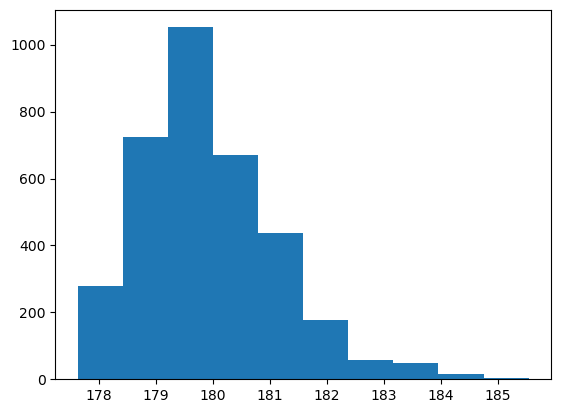

In [48]:
plt.hist([h for h in gdf_points_updated['grd_elev_building_max'] if h is not None])

## Export statistics to file

In [49]:
out_file=r'D:\Wagga\GSV\Final_Wagga_meta_camera_height_ground_elevations.geojson'
gdf_points_updated.to_file(out_file, driver="GeoJSON")